In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-04-25 02:21:08.150910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 02:21:08.260581: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 02:21:08.680979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-04-25 02:21:08.681020: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12286
12286
12286
12286
12286
12286
12286
12286


In [7]:
######################
# ONLY HITS_bot DATA #
######################

# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000



hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    
    
# close the h5 files
f_B.close()
f_S.close()



# X and Y for the classifier
X_mon = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_mon = scaler.fit_transform(X_mon)

del hits_bot_B
del hits_bot_S

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (9999, 121)
y_mon_train :  (9999,)
X_mon_val :  (3334, 121)
y_mon_val :  (3334,)
X_mon_test :  (6667, 121)
y_mon_test :  (6667,)



### CLASSIFIER

[0]	validation_0-error:0.36784	validation_0-logloss:0.68228	validation_0-map:0.63614	validation_1-error:0.40102	validation_1-logloss:0.68539	validation_1-map:0.60064
[1]	validation_0-error:0.33303	validation_0-logloss:0.67261	validation_0-map:0.67429	validation_1-error:0.37133	validation_1-logloss:0.67838	validation_1-map:0.63446
[2]	validation_0-error:0.32483	validation_0-logloss:0.66385	validation_0-map:0.68860	validation_1-error:0.35303	validation_1-logloss:0.67192	validation_1-map:0.64781
[3]	validation_0-error:0.31493	validation_0-logloss:0.65572	validation_0-map:0.69500	validation_1-error:0.34433	validation_1-logloss:0.66674	validation_1-map:0.64817
[4]	validation_0-error:0.30593	validation_0-logloss:0.64839	validation_0-map:0.70417	validation_1-error:0.34493	validation_1-logloss:0.66164	validation_1-map:0.65621
[5]	validation_0-error:0.30293	validation_0-logloss:0.64147	validation_0-map:0.70568	validation_1-error:0.34313	validation_1-logloss:0.65728	validation_1-map:0.65734


/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.30003	validation_0-logloss:0.63525	validation_0-map:0.70711	validation_1-error:0.33983	validation_1-logloss:0.65388	validation_1-map:0.65422
[7]	validation_0-error:0.29553	validation_0-logloss:0.62939	validation_0-map:0.71357	validation_1-error:0.34133	validation_1-logloss:0.65009	validation_1-map:0.65847
[8]	validation_0-error:0.29633	validation_0-logloss:0.62395	validation_0-map:0.71673	validation_1-error:0.33713	validation_1-logloss:0.64679	validation_1-map:0.66338
[9]	validation_0-error:0.29173	validation_0-logloss:0.61869	validation_0-map:0.72032	validation_1-error:0.33503	validation_1-logloss:0.64398	validation_1-map:0.66511
[10]	validation_0-error:0.28843	validation_0-logloss:0.61381	validation_0-map:0.72142	validation_1-error:0.33263	validation_1-logloss:0.64085	validation_1-map:0.66687
[11]	validation_0-error:0.28963	validation_0-logloss:0.60916	validation_0-map:0.72244	validation_1-error:0.33203	validation_1-logloss:0.63823	validation_1-map:0.66726
[1

[56]	validation_0-error:0.24022	validation_0-logloss:0.52557	validation_0-map:0.75787	validation_1-error:0.31764	validation_1-logloss:0.61465	validation_1-map:0.67665
[57]	validation_0-error:0.23962	validation_0-logloss:0.52480	validation_0-map:0.75819	validation_1-error:0.31854	validation_1-logloss:0.61479	validation_1-map:0.67667
[58]	validation_0-error:0.23862	validation_0-logloss:0.52361	validation_0-map:0.75817	validation_1-error:0.31704	validation_1-logloss:0.61486	validation_1-map:0.67638
[59]	validation_0-error:0.23782	validation_0-logloss:0.52312	validation_0-map:0.75860	validation_1-error:0.31734	validation_1-logloss:0.61498	validation_1-map:0.67642
[60]	validation_0-error:0.23772	validation_0-logloss:0.52273	validation_0-map:0.75868	validation_1-error:0.31734	validation_1-logloss:0.61479	validation_1-map:0.67670
[61]	validation_0-error:0.23702	validation_0-logloss:0.52236	validation_0-map:0.75890	validation_1-error:0.31794	validation_1-logloss:0.61469	validation_1-map:0.6766

[106]	validation_0-error:0.20652	validation_0-logloss:0.49589	validation_0-map:0.77972	validation_1-error:0.31644	validation_1-logloss:0.61665	validation_1-map:0.67915
[107]	validation_0-error:0.20582	validation_0-logloss:0.49545	validation_0-map:0.78007	validation_1-error:0.31674	validation_1-logloss:0.61659	validation_1-map:0.67956
[108]	validation_0-error:0.20462	validation_0-logloss:0.49458	validation_0-map:0.78075	validation_1-error:0.31674	validation_1-logloss:0.61686	validation_1-map:0.67957
[109]	validation_0-error:0.20382	validation_0-logloss:0.49382	validation_0-map:0.78179	validation_1-error:0.31614	validation_1-logloss:0.61705	validation_1-map:0.67934
[110]	validation_0-error:0.20312	validation_0-logloss:0.49298	validation_0-map:0.78305	validation_1-error:0.31584	validation_1-logloss:0.61724	validation_1-map:0.67888
[111]	validation_0-error:0.20222	validation_0-logloss:0.49246	validation_0-map:0.78340	validation_1-error:0.31554	validation_1-logloss:0.61740	validation_1-map:

[155]	validation_0-error:0.17502	validation_0-logloss:0.46555	validation_0-map:0.81053	validation_1-error:0.32094	validation_1-logloss:0.61984	validation_1-map:0.67704
[156]	validation_0-error:0.17342	validation_0-logloss:0.46445	validation_0-map:0.81122	validation_1-error:0.32094	validation_1-logloss:0.62018	validation_1-map:0.67701
[157]	validation_0-error:0.17332	validation_0-logloss:0.46423	validation_0-map:0.81147	validation_1-error:0.32094	validation_1-logloss:0.62025	validation_1-map:0.67708
[158]	validation_0-error:0.17272	validation_0-logloss:0.46370	validation_0-map:0.81186	validation_1-error:0.32094	validation_1-logloss:0.62023	validation_1-map:0.67701
[159]	validation_0-error:0.17272	validation_0-logloss:0.46323	validation_0-map:0.81207	validation_1-error:0.32034	validation_1-logloss:0.62010	validation_1-map:0.67704
[160]	validation_0-error:0.17272	validation_0-logloss:0.46298	validation_0-map:0.81230	validation_1-error:0.32094	validation_1-logloss:0.62031	validation_1-map:

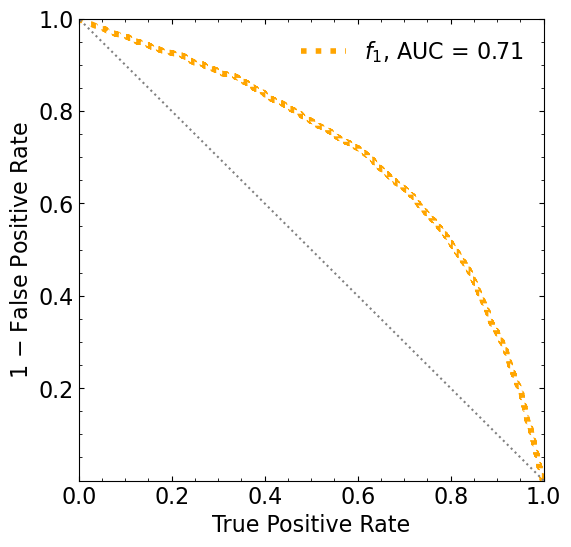

In [55]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric=["error", "logloss", "map"],early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

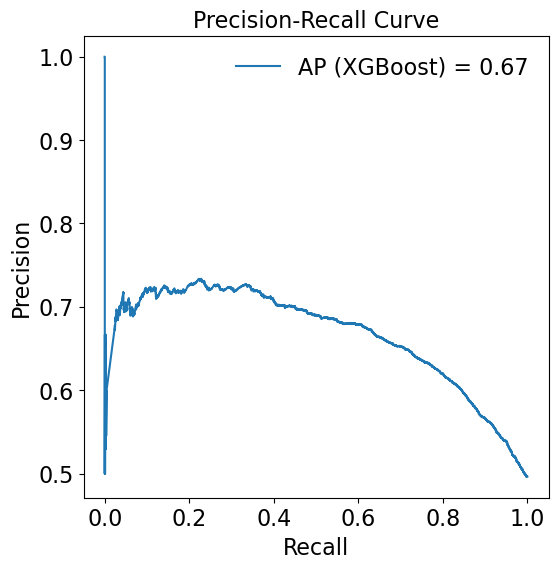

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_xg, recall_xg, _ = precision_recall_curve(y_mon_test, y_pred_xg)
auc_xg = auc(recall_xg, precision_xg)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_xg, precision_xg, label=f'AP (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

Accuracy: 66.57%


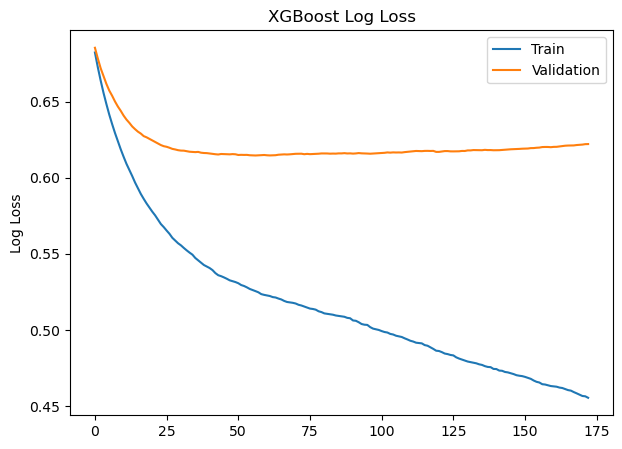

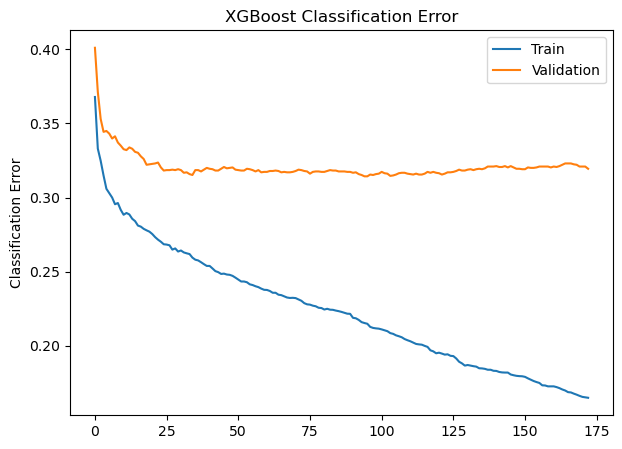

In [68]:
predictions = [round(value) for value in y_pred_xg]
accuracy = accuracy_score(y_mon_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)


# plot log loss
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Classification score:


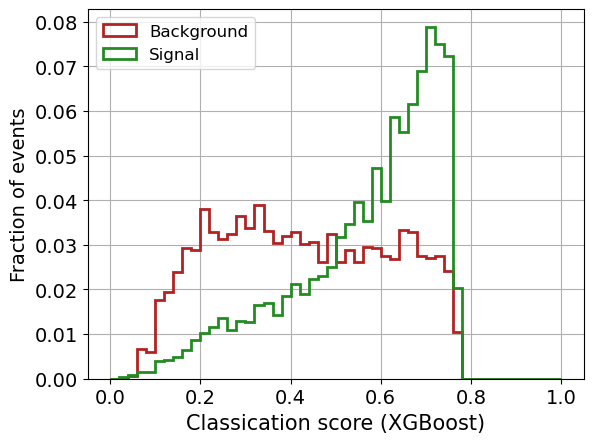

In [9]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()